In [24]:
%%bash 
pip install robustness 2>> install.log
git clone https://github.com/ShibaniSanturkar/IAP_InterpretabilityClass.git 2>>install.log
cd IAP_InterpretabilityClass
wget http://people.csail.mit.edu/tsipras/stuff.zip 2>> install.log
unzip stuff 2>>install.log

Cloning into 'IAP_InterpretabilityClass'...


In [0]:
try: # set up path
    import google.colab, sys, torch
    sys.path.append('/content/tutorial_code')
    if not torch.cuda.is_available():
        print("Change runtime type to include a GPU.")  
except:
    pass

In [6]:
# Import basic libraries needed for the exercise (numpy, matplotlib, and torch)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch as ch
import torchvision.transforms as transforms

# We also use the robustness library (https://robustness.readthedocs.io/en/latest/) for some 
# convenient functionality.
from robustness.tools.vis_tools import show_image_row

import helpers 

%matplotlib inline

ModuleNotFoundError: ignored

# Excercise I: Gradients as model interpretations

## Load dataset 

For our interpretability experiments, we will use the ImageNet dataset from the ILSVRC challenge. This is a 1000 class dataset, that has played an important role in developing and evaluating deep learning models.

In [0]:
# Creater a dataset, and a loader to access it. In addition to the loader, we also need to obtain a
# normalization function. This is because standard deep networks are typically trained 
# on normalized images, so we need to apply the same normalization during testing. Finally,
# we also get a label map, that tells us what class a corresponding numeric value corresponds
# to.
in_dataset, in_loader, normalization_function, label_map_IN = helpers.load_dataset('imagenet',
                                                                 batch_size=5,
                                                                 num_workers=1)

==> Preparing dataset imagenet..


We can visualize some samples, along with their labels, from the dataset as follows

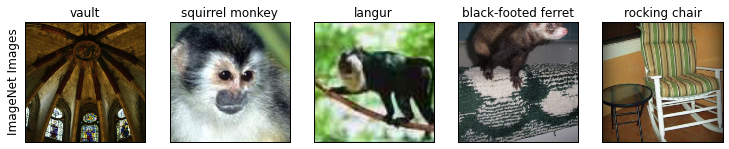

In [0]:
_, (img, targ) = next(enumerate(in_loader))

show_image_row([img],
              ["ImageNet Images"],
              tlist=[[label_map_IN[int(t)].split(',')[0] for t in targ]])

## Load model

Next, we need a model to interpret! PyTorch provides access to a large range of pre-trained deep networks (for a full list, see <https://pytorch.org/docs/stable/torchvision/models.html>). For example, we can load a ResNet18 using the following code.

In [0]:
std_model = helpers.load_model('resnet18')

### Compute and visualize gradient

In [0]:
# We compute the gradient of the loss, with respect to the input. For every image pixel,
# the gradient tells us how the loss changes if we vary that pixel slightly.

grad, _ = helpers.get_gradient(std_model, img, targ, normalization_function)

# We can then visualize the original image, along with the gradient. Note that the gradient may
# not lie within the valid pixel range ([0, 1]), so we need to rescale it using the 
# `visualize_gradient` function.

show_image_row([img, helpers.visualize_gradient(grad)],
              ["Original Image", "Gradient"],
              tlist=[[label_map_IN[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

# Exercise II:  Try SmoothGrad and visualize the interpretations

Fill in the following skeleton to implement SmoothGrad.

`def smooth_grad(mod, im, targ, normalization, Nsamples, stdev):
    it = tqdm(enumerate(range(Nsamples)), total=Nsamples)
    total_grad = 0
    for _, n in it:
        ...
        grad, _ = helpers.get_gradient(mod, noised_im, targ, normalization)
        total_grad += grad
    return total_grad / Nsamples`
    
Then, try using SmoothGrad to interpret a standard model

In [0]:
def smooth_grad(mod, im, targ, normalization,
                Nsamples, stdev):
    # Instead of taking the gradient of a single image, we will take gradients
    # at a bunch of neighborhood points and average their gradients.
    
    it = tqdm(enumerate(range(Nsamples)), total=Nsamples)

    total_grad = 0
    for _, n in it:
        
        # Create a noisy version of the input image
        noise = ch.tensor(np.random.normal(0, stdev, im.shape), dtype=im.dtype)
        noised_im = im + noise
        # Compute gradient at noised version of the image
        grad, _ = helpers.get_gradient(mod, noised_im, targ, normalization)
        total_grad += grad
    
    # Return average gradient
    return total_grad / Nsamples

In [0]:
sgrad = smooth_grad(std_model, img, targ, normalization_function,
                    100, 0.3)

In [0]:
# We once again use the `visualize_gradient` helper to make the SmoothGrad suitable for 
# visualization.

show_image_row([img, helpers.visualize_gradient(sgrad)],
              ["Original Image", "SmoothGrad"],
               tlist=[[label_map_IN[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

# Excercise III: Adversarial examples

Since its discovery, the existance of adversarial examples has been one of the most extensively studied phenomena in deep learning. Essentially, it turns out that one can add an *imperceptible* perturbation to any input image and a standard (highly accurate) classifier will misclassify it (or classify it as an adversarially chosen class). 

*Finding adversarial examples:* The idea is pretty simple: given a target class (t), we want to find a perturbation ($\delta'$) that when added to the input (x) maximizes the likelihood of the target class. At the same time, we want the perturbation to be small: for example lie in a tiny L2 ball around the image. Basically, we want to find a $\delta'$ such that

$\delta' = argmax_{||\delta||_2 \leq \epsilon} L(x + \delta, t; \theta)$


To find a perturbation that maximizes the objective (likelihood) while remaining in a bounded set, we use projected gradient descent PGD (see <https://arxiv.org/abs/1706.06083> for more). 

### Try it yourself! 

First choose a target class for every input. (Note that you have a batch of inputs, so you could try different targets for different inputs.)

In [0]:
TARGET = 3

print(f"Target class: {label_map_IN[TARGET]}")

target_class = TARGET * ch.ones_like(targ)

Next, there are a couple of parameters that you need to choose: 
1. eps: maximum size of the perturbation in terms of L2 norm. For e.g., eps=2 implies that $||\delta||_2 \leq 2$
2. Nsteps: number of (projected) gradient descent to perform
3. step_size: size of each step of (projected) gradient descent

Try varying these parameters and see what happens.

In [0]:
# Create adversarial examples
adv_ex = helpers.L2PGD(std_model, img, target_class, normalization_function,
                       step_size=0.5, Nsteps=20, 
                       eps=1.25, targeted=True)

### Evaluate model predictions at perturbed inputs

To see if our attack was successful, we will now evaluate model predictions at the perturbed inputs. We would expect the predicted label to match the `target_class` used above, if we succeeded.

In [0]:
with ch.no_grad():
    logits = helpers.forward_pass(std_model, 
                                      adv_ex, 
                                      normalization_function)
    pred_label = logits.argmax(dim=1)

### Visualize adversarial examples

We now inspect the original (unperturbed) inputs (*top*), along with the corresponding adversarial examples (*bottom*). We also look at what the model predicts for each row of images.

Does the attack succeed? Do the adversarial examples look different from the original inputs?

In [0]:
show_image_row([img, adv_ex], 
               ['Original image', 'Adv. Example'],
               tlist=[[label_map_IN[int(t)].split(',')[0] for t in label] \
                      for label in [targ, pred_label]])

# Excercise IV: Playing with robust models

The existance of adversarial examples has also prompted a large body of research to build models that are robust to these perturbations, i.e., so-called *robust models*. One approach to get a robust model is to train against the PGD adversary: instead of minimizing the loss over training examples, we minimize the loss against adversarially perturbed training samples (obtained using PGD). We will now take a closer look at robust models.

### Loading a robust model

For our study today, we will use a pre-trained robust model. We trained this model (ResNet50) on a 9-class subset of the ImageNet dataset. (Developing good robust models for the more complex 1000 class version is still an active area of research.)

In [0]:
# Load the "Restricted" ImageNet dataset
restricted_imagenet_ds, rin_loader, normalization_function, label_map_RIN = \
            helpers.load_dataset('restricted_imagenet', batch_size=5, num_workers=1)

# Load a pre-trained robust model
robust_model = helpers.load_model('robust', restricted_imagenet_ds)

### Can adversarial examples fool a robust model?

We can now try to fool the robust model using the same procedure as before. Does it succeed? Try varying the attack parameters and see what happens.

In [0]:
# Load images from the Restricted ImageNet dataset
_, (img, targ) = next(enumerate(rin_loader))

# Then we choose a target label for the attack.
TARGET = 3

print(f"Target class: {label_map_RIN[TARGET]}")

target_class = TARGET * ch.ones_like(targ)

# Create adversarial examples
adv_ex = helpers.L2PGD(robust_model, img, target_class, normalization_function,
                       step_size=0.5, Nsteps=20, eps=1.25, targeted=True)

# Evaluate model predictions
with ch.no_grad():
    logit = helpers.forward_pass(robust_model, adv_ex, normalization_function)
    pred_label = logit.argmax(dim=1)

# Visualize adversarial examples

show_image_row([img, adv_ex], 
               ['Original image', 'Adv. Example'],
               tlist=[[label_map_RIN[int(t)].split(',')[0] for t in label] \
                      for label in [targ, pred_label]])

# Excercise V: Changing the prediction of a robust model

We know that robust models are not easily fooled by adversarial examples. This tells us that one cannot change the prediction of a robust model using imperceptible L2 perturbations to the input (in contrast to standard models). How can we then modify the input to make the robust model predict a different class?

Try creating adversarial examples as before, but with a larger eps. Our hope is that by increasing the size of the perturbation set, we can find a perturbation that actually causes the model to change its prediction? What do the perturbed inputs, i.e., "*large epsilon adversarial examples*" look like?

In [0]:
TARGET = 5

print(f"Target class: {label_map_RIN[TARGET]}")

target_class = TARGET * ch.ones_like(targ)

im_targ = helpers.L2PGD(robust_model, img, target_class, normalization_function,
                        step_size=5, Nsteps=20, eps=100, targeted=True)

# Evaluate model predictions
with ch.no_grad():
    logit = helpers.forward_pass(robust_model, im_targ, normalization_function)
    pred_label = logit.argmax(dim=1)

In [0]:
show_image_row([img, im_targ],
              ['Original image', 'Large eps \n adv. example'],
               tlist=[[label_map_RIN[int(t)].split(',')[0] for t in label] \
                      for label in [targ, pred_label]])

# Excercise VI: Interpretations for robust models

Based on the previous experiment, we know that, for robust models, (a) imperceptible input changes do not change the prediction and (b) to change the prediction, we actually need to change "salient image features".

Does this mean that the features that robust models rely on are more human-aligned in a sense?

### VI.I Let's start by looking at their gradients.

What do the gradients of robust models look like? How do they compare to the gradients of a standard model and the output of SmoothGrad?

In [0]:
# Get gradient of the loss with respect to the input
grad_rob, _ = helpers.get_gradient(robust_model, img, targ, normalization_function)

# Visualize gradient
show_image_row([img, helpers.visualize_gradient(grad_rob)],
              ["Original Image", "Gradient"],
              tlist=[[label_map_RIN[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

### VI.2 Feature Visualization

Another popular interpretability technique is known as feature visualization. Here, the goal is to find an input that maximizes a feature (a particular neuron in the deep network), instead of just trying to maximize the loss (as we did before with gradients).

You could now try to implement feature visualization yourself. For instance, the following function gives you, for specific inputs, the model's feature vector (the layer before the final linear classifier). 

In [0]:
# Getting the feature representation from the model
with ch.no_grad():
    feats = helpers.get_features(robust_model, img, normalization_function)
    print(f"Dimensions of the feature vector: {feats.shape[1]}")

#### Implement a loss function to perform feature visualization

Fill in the skeleton below to create a feature visualization loss function. Our goal is to maximize the `feature_number` coordinate of the feature vector.

`def feature_maximization_loss(mod, im, feature_number, normalization_function):
    feature_vector = helpers.get_features(mod, im, normalization) # Get features for input
    relevant_coordinate = ch.gather(feature_vector, 1, feature_number[:, None]) 
    loss = ?
    ...
    return loss`

In [0]:
# Feature visualization loss: Try to find an input that maximizes a specific feature

def feature_maximization_loss(mod, im, feature_number, normalization):
    # Get feature vector for inputs
    fr = helpers.get_features(mod, im, normalization)
    # We will maximize the `targ` coordinate of the feature vector for every input
    loss = ch.mean(ch.gather(fr, 1, feature_number[:, None]))
    return loss

#### Visualize the results of feature visualization

You can then supply the `feature_maximization_loss` to the `custom_loss` argument input in `helpers.L2PGD`, and maximize it using the following snippet.

In [0]:
# Chose a feature to visualize
FEATURE = 200 # should be less than the dimension from before

target_feature = FEATURE * ch.ones_like(targ)

In [0]:
# Maximize feature 
im_f = helpers.L2PGD(robust_model, img, target_feature, normalization_function,
                              step_size=5, Nsteps=20, eps=1000, 
                              custom_loss=feature_maximization_loss, 
                              targeted=False)

In [0]:
# Visualize results
show_image_row([img, im_f],
               ["Original Image", f"Maximize Feature #{FEATURE}"])

#### Try the same for a standard model

In [0]:
# Load image-label pair from ImageNet
_, (img, targ) = next(enumerate(in_loader))

TARGET = 100 
target_feature = TARGET * ch.ones_like(targ)
im_f = helpers.L2PGD(std_model, img, target_feature, normalization_function,
                              step_size=5, Nsteps=20, eps=1000, 
                              custom_loss=feature_maximization_loss, 
                              targeted=False)

In [0]:
show_image_row([img, im_f],
               ["Original Image", f"Maximize Feature #{FEATURE}"])

# Bonus Excercise I: Try feature visualization for robust models starting from noise rather than images

What if we try feature visualization starting from noise?

In [0]:
# Create a "noise" image
noise_img = ch.clamp(ch.randn_like(img) + 0.5, 0, 1)

FEATURE = 201
target_feature = FEATURE * ch.ones_like(targ)
im_f = helpers.L2PGD(robust_model, noise_img, target_feature, normalization_function,
                     step_size=5, Nsteps=200, eps=1000, 
                     custom_loss=feature_maximization_loss, 
                     targeted=False)

In [0]:
show_image_row([noise_img, im_f],
                ["Original Image", f"Maximize Feature #{FEATURE}"])